In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
%matplotlib inline

In [6]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z)) 
        
def relu(Z):
    return np.maximum(0, Z)

def tanh(Z):
    return np.tanh(Z)
    
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis = 0, keepdims = True)
    

In [189]:
class Neural_network():
    '''
    Class for a neural network.
    '''
    
    def __init__(self, layer_sizes, layer_activations, learning_rate, epochs, dropout = 1, beta1 = 0.9, beta2 = 0.999, 
                 epsilon = 1e-8):
        '''
        initialize the neural network.
        '''
        self.layer_sizes = layer_sizes
        self.layer_activations = layer_activations
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.epochs = epochs
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        # Initialize parameters of each layer
        self.params = {}
        for i in range(1, len(layer_sizes)):
            self.params['W' + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * 0.01
            self.params['b' + str(i)] = np.zeros((layer_sizes[i], 1))
            
        # Initialize velocity and stuff for Adam
        self.v = {}
        self.s = {}
        
        for i in range(1, len(layer_sizes)):

            self.v["dW" + str(i)] = np.zeros(self.params["W" + str(i)].shape)
            self.v["db" + str(i)] = np.zeros(self.params["b" + str(i)].shape)
            self.s["dW" + str(i)] = np.zeros(self.params["W" + str(i)].shape)
            self.s["db" + str(i)] = np.zeros(self.params["b" + str(i)].shape)
            
            
    def forward_prop(self, X, dropout = False):
        '''
        Performs forward propagation for an iteration.
        '''
        
        A_prev = X
        Z = [0]
        A = [A_prev]
        self.D = []
        
        for i in range(1, len(self.layer_sizes)):
            
            Zi = np.dot(self.params['W' + str(i)], A_prev) + self.params['b' + str(i)]
            if self.layer_activations[i - 1] == 'sigmoid':
                A_prev = sigmoid(Zi)
            elif self.layer_activations[i - 1] == 'relu':
                A_prev = relu(Zi)
            elif self.layer_activations[i - 1] == 'tanh':
                A_prev = tanh(Zi)
            elif self.layer_activations[i - 1] == 'linear':
                A_prev = Zi
            elif self.layer_activations[i - 1] == 'softmax':
                A_prev = softmax(Zi)

            # Don't apply dropout on output layer
            if i != len(self.layer_sizes) - 1 and dropout:
            # Apply dropout 
                Di = np.random.rand(A_prev.shape[0], A_prev.shape[1])
                Di = (Di < self.dropout).astype(int)
                A_prev = A_prev * Di
                A_prev = A_prev / self.dropout
                self.D.append(Di)
            
            A.append(A_prev)
            Z.append(Zi)

        return A, Z
    
    
    def compute_cost(self, Y, Y_hat):
        '''
        Computes the cost of an iteration
        '''
        
        m = Y.shape[1]
        
        if self.layer_activations[-1] == 'sigmoid':
            cost = - np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m 
        elif self.layer_activations[-1] == 'linear':
            cost = np.sum((Y_hat - Y) ** 2) / (2 * m)
        elif self.layer_activations[-1] == 'softmax':
            cost = - np.sum(Y * np.log(Y_hat)) / m
        
        return np.squeeze(cost)
    
    
    def back_prop(self, X, Y, A, Z):
        m = X.shape[1]
        grads = {}
        L = len(self.layer_sizes) - 1
        
        if self.layer_activations[-1] == 'sigmoid':
            dAL = - (np.divide(Y, A[-1]) - np.divide(1 - Y, 1 - A[-1]))
            dZL = A[-1] * (1 - A[-1]) * dAL
        elif self.layer_activations[-1] == 'linear':
            dAL = A[-1] - Y
            dZL = dAL
        elif self.layer_activations[-1] == 'softmax':
            dAL = - Y / A[-1]
            
        A_prev = A[-2]
        
        grads['dW' + str(L)] = np.dot(dZL, A_prev.T) / m
        grads['db' + str(L)] = np.sum(dZL, axis = 1, keepdims = True) / m
        dA_prev = np.dot(self.params['W' + str(L)].T, dZL)
        
        for i in reversed(range(L - 1)):

            dA_prev = dA_prev * self.D[i]
            dA_prev = dA_prev / self.dropout
            Zi = Z[i + 1]
            if self.layer_activations[i] == 'sigmoid':
                dZl = A_prev * (1 - A_prev) * dA_prev
            elif self.layer_activations[i] == 'relu': 
                dZl = np.array(dA_prev, copy=True)
                dZl[Zi <= 0] = 0
            elif self.layer_activations[i] == 'tanh':
                dZl = (1 - A_prev) * dA_prev

            A_prev = A[i]
            
            grads['dW' + str(i + 1)] = np.dot(dZl, A_prev.T) / m
            grads['db' + str(i + 1)] = np.sum(dZl, axis=1, keepdims=True) / m
            dA_prev = np.dot(self.params['W' + str(i + 1)].T, dZl)
            
        return grads
    

    def fit(self, X_train, Y_train, X_dev, Y_dev):
        train_cost = 0
        dev_cost = 0
        train_costs = []
        dev_costs = []
        for epoch in range(self.epochs):
            A, Z = self.forward_prop(X_train, True)
            train_cost = self.compute_cost(Y_train, A[-1])
            grads = self.back_prop(X_train, Y_train, A, Z)
            self.update_params(grads, epoch + 1)
            train_costs.append(train_cost)

            Ad, _ = self.forward_prop(X_dev)
            dev_cost = self.compute_cost(Y_dev, Ad[-1])
            dev_costs.append(dev_cost)
            
            if epoch % 1000 == 0:
                print(f"Cost at epoch {epoch} is: Train: {train_cost}, Dev: {dev_cost}")
        print(f"Final cost is: Train: {train_cost}, Dev: {dev_cost}")        
        plt.plot(train_costs, label = "Train")
        plt.plot(dev_costs, label = "Dev")
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.legend()

        A, Z = self.forward_prop(X_train)
        Ad, _ = self.forward_prop(X_dev)
        train_acc = np.sum((np.abs(Y_train - A[-1]) < 20)) / Y_train.shape[1]
        dev_acc = np.sum((np.abs(Y_dev - Ad[-1]) < 20)) / Y_dev.shape[1]
        print(f"The accuracy on train set is : {train_acc * 100:.2f} %")
        print(f"The accuracy on dev set is : {dev_acc * 100: .2f} %")
        
    
    def update_params(self, grads, t):
        # Correction for moving averages
        self.v_corrected = {}            
        self.s_corrected = {} 
        for i in range(1, len(self.layer_sizes)):
            self.v["dW" + str(i)] = self.beta1 * self.v["dW" + str(i)] + (1 - self.beta1) * grads["dW" + str(i)]
            self.v["db" + str(i)] = self.beta1 * self.v["db" + str(i)] + (1 - self.beta1) * grads["db" + str(i)]   
            
            # Bias correction
            self.v_corrected["dW" + str(i)] = self.v["dW" + str(i)] / (1 - self.beta1 ** t)
            self.v_corrected["db" + str(i)] = self.v["db" + str(i)] / (1 - self.beta1 ** t)
            
            # Almost same stuff as v, just with square
            self.s["dW" + str(i)] = self.beta2 * self.s["dW" + str(i)] + (1 - self.beta2) * (grads["dW" + str(i)] ** 2)
            self.s["db" + str(i)] = self.beta2 * self.s["db" + str(i)] + (1 - self.beta2) * (grads["db" + str(i)] ** 2) 
            
            self.s_corrected["dW" + str(i)] = self.s["dW" + str(i)] / (1 - self.beta2 ** t)
            self.s_corrected["db" + str(i)] = self.s["db" + str(i)] / (1 - self.beta2 ** t)
            
            self.params['W' + str(i)] -= self.learning_rate * (self.v_corrected['dW' + str(i)] / np.sqrt(self.s_corrected['dW' + str(i)] + self.epsilon))
            self.params['b' + str(i)] -= self.learning_rate * (self.v_corrected['db' + str(i)] / np.sqrt(self.s_corrected['db' + str(i)] + self.epsilon))
            
            
    def test(self, X, Y):
        A, _ = self.forward_prop(X)
        cost = self.compute_cost(Y, A[-1])
        print(f"The cost on test set is {cost}")
        test_acc = np.sum((np.abs(Y - A[-1]) < 20)) / Y.shape[1]
        print(f"The accuracy on test set is : {test_acc * 100:.2f} %")
        
        return
        
        
    def predict(self, X):
        A, _ = self.forward_prop(X)
        print(f"The model predicts a final score of : {int(A[-1])}")
        return 
       

Cost at epoch 0 is 20.33395162530945
Cost at epoch 1000 is 0.8261910632086774
Cost at epoch 2000 is 0.3257791035515034
Cost at epoch 3000 is 0.08548812466704474
Cost at epoch 4000 is 0.01123338007946425
Cost at epoch 5000 is 0.0004267522868075343
Cost at epoch 6000 is 1.8878084051756014e-06
Cost at epoch 7000 is 2.2804057252854837e-10
Cost at epoch 8000 is 7.355967616994088e-17
Cost at epoch 9000 is 2.092867703073975e-27
Predicted Y for X_test: [[5.99999994]]


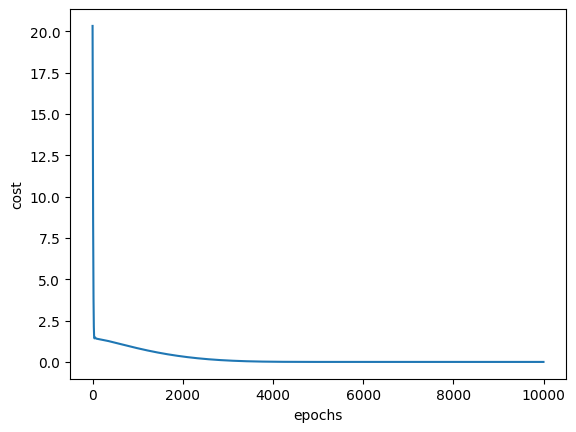

In [4]:
# Generate synthetic data
X_train = np.random.rand(1, 100)
Y_train = 6 * X_train + 3

# Create and train the neural network
model = Neural_network(layer_sizes=[1, 3, 1], layer_activations=['relu', 'linear'], learning_rate=0.2, epochs=10000)
costs = model.fit(X_train, Y_train)

# Test the model
X_test = np.array([[0.5]])
predicted_y = model.predict(X_test)
print(f"Predicted Y for X_test: {predicted_y}")

In [8]:
# Read the match data csv
match_data = pd.read_csv("match_data.csv")
match_data.head()

C:\Users\athar\AppData\Local\Temp\ipykernel_10420\4016351506.py:2: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  match_data = pd.read_csv("match_data.csv")


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,batter,bowler,non_striker,batter runs,extra runs,total runs,score,extras,wickets,out,Total Wickets,non_boundary,review,replacements
0,1381452,Austria,0,0,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,0,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
1,1381452,Austria,0,1,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,4,0,4,4,NaN,NaN,0,0,NaN,NaN,NaN
2,1381452,Austria,0,2,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,0,0,0,4,NaN,NaN,0,0,NaN,NaN,NaN
3,1381452,Austria,0,3,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,0,0,0,4,NaN,NaN,0,0,NaN,NaN,NaN
4,1381452,Austria,0,4,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,1,0,1,5,NaN,NaN,0,0,NaN,NaN,NaN


In [9]:
# Rename columns and set index
match_data = match_data.set_index(["Unnamed: 0"])
match_data.index.names = ["Match Code"]
new_names = {'Unnamed: 1': 'country', 'Unnamed: 2': 'over', 'Unnamed: 3': 'ball', 'score' : "current_score", "Total Wickets" : "total_wickets"}
match_data.rename(columns = new_names, inplace = True)
match_data

,country,over,ball,batter,bowler,non_striker,batter runs,extra runs,total runs,current_score,extras,wickets,out,total_wickets,non_boundary,review,replacements
Match Code,,,,,,,,,,,,,,,,,
1381452,Austria,0,0,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,0,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
1381452,Austria,0,1,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,4,0,4,4,NaN,NaN,0,0,NaN,NaN,NaN
1381452,Austria,0,2,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,0,0,0,4,NaN,NaN,0,0,NaN,NaN,NaN
1381452,Austria,0,3,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,0,0,0,4,NaN,NaN,0,0,NaN,NaN,NaN
1381452,Austria,0,4,M Simpson-Parker,Ghulam Ahmadi,Iqbal Hossain,1,0,1,5,NaN,NaN,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211048,New Zealand,19,1,JW Wilson,GD McGrath,KD Mills,2,0,2,165,NaN,NaN,0,8,NaN,NaN,NaN
211048,New Zealand,19,2,JW Wilson,GD McGrath,KD Mills,0,0,0,165,NaN,"[{'kind': 'bowled', 'player_out': 'JW Wilson'}]",1,9,NaN,NaN,NaN
211048,New Zealand,19,3,DR Tuffey,GD McGrath,KD Mills,4,0,4,169,NaN,NaN,0,9,NaN,NaN,NaN


In [10]:
# Extract the perceived useful features for predicting final score
match_data_1 = match_data[["country", "over", "ball", "current_score", "total_wickets"]]
match_data_1

,country,over,ball,current_score,total_wickets
Match Code,,,,,
1381452,Austria,0,0,0,0
1381452,Austria,0,1,4,0
1381452,Austria,0,2,4,0
1381452,Austria,0,3,4,0
1381452,Austria,0,4,5,0
...,...,...,...,...,...
211048,New Zealand,19,1,165,8
211048,New Zealand,19,2,165,9
211048,New Zealand,19,3,169,9


In [11]:
# Create a new column for final score, we want to predict this

final_scores = match_data_1.groupby(["Match Code", "country"]).last().reset_index()
match_data_1 = match_data_1.merge(final_scores[["Match Code", "country", "current_score"]],
                                 on = ["Match Code", "country"], suffixes = ('', "_final"))
match_data_1.rename(columns={'current_score_final': 'final_score'}, inplace=True)
match_data_1


,Match Code,country,over,ball,current_score,total_wickets,final_score
0,1381452,Austria,0,0,0,0,121
1,1381452,Austria,0,1,4,0,121
2,1381452,Austria,0,2,4,0,121
3,1381452,Austria,0,3,4,0,121
4,1381452,Austria,0,4,5,0,121
...,...,...,...,...,...,...,...
407784,211048,New Zealand,19,1,165,8,170
407785,211048,New Zealand,19,2,165,9,170
407786,211048,New Zealand,19,3,169,9,170
407787,211048,New Zealand,19,4,170,9,170


In [12]:
match_data_1.drop(columns=["Match Code", "country"])

,over,ball,current_score,total_wickets,final_score
0,0,0,0,0,121
1,0,1,4,0,121
2,0,2,4,0,121
3,0,3,4,0,121
4,0,4,5,0,121
...,...,...,...,...,...
407784,19,1,165,8,170
407785,19,2,165,9,170
407786,19,3,169,9,170
407787,19,4,170,9,170


In [119]:
# Specify the X and Y labels
X = match_data_1[["over", "ball", "current_score", "total_wickets"]].to_numpy()
Y = match_data_1[["final_score"]].to_numpy()
X = X.T
Y = Y.T
print(X.shape)
print(Y.shape)

(4, 407789)
(1, 407789)


In [120]:
# Split into train/dev and test sets
train_ratio = 0.96
dev_ratio = 0.02
# Test and dev ratio are same

total_examples = X.shape[1]
train_size = int(train_ratio * total_examples)
dev_size = int(dev_ratio * total_examples)


# Shuffle the arrays
indices = np.random.permutation(total_examples)
X, Y = X[:,indices], Y[:,indices]
#X, Y = X[indices], Y[indices]

# Finally, split the data
X_train, X_dev, X_test = X[:,:train_size], X[:,train_size:train_size + dev_size], X[:, train_size + dev_size:]
Y_train, Y_dev, Y_test = Y[:,:train_size], Y[:,train_size:train_size + dev_size], Y[:, train_size + dev_size:]
#X_train, X_dev, X_test = X[:train_size], X[train_size:train_size + dev_size], X[train_size + dev_size:]
#Y_train, Y_dev, Y_test = Y[:train_size], Y[train_size:train_size + dev_size], Y[train_size + dev_size:]



Cost at epoch 0 is: Train: 10888.980169567194, Dev: 7544.235614899093
Cost at epoch 1000 is: Train: 392.7021465926011, Dev: 403.5931808061532
Final cost is: Train: 384.41193572620864, Dev: 396.3155128933439
The accuracy on train set is : 62.26 %
The accuracy on dev set is :  62.56 %
The cost on test set is 379.121070167219
The accuracy on test set is : 62.74 %


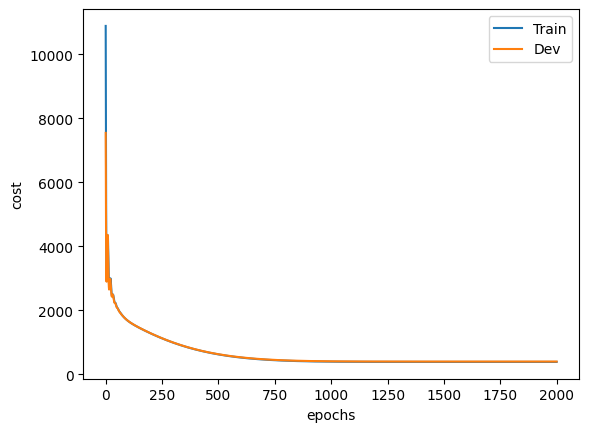

In [171]:
# Now create and train the model
final_score_predictor = Neural_network(layer_sizes=[4, 1], layer_activations=['linear'], 
                                      learning_rate = 0.3, epochs = 2000)

final_score_predictor.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor.test(X_test, Y_test)

In [187]:
final_score_predictor.predict([[19], [0], [80], [2]])

The model predicts a final score of : 142


Cost at epoch 0 is: Train: 11068.012875912553, Dev: 9664.18646728676
Cost at epoch 1000 is: Train: 520.4965070406699, Dev: 443.04385369222285
Final cost is: Train: 514.4030593614985, Dev: 455.2771839825182
The accuracy on train set is : 56.37 %
The accuracy on dev set is :  56.43 %
The cost on test set is 442.426373377151
The accuracy on test set is : 56.79 %


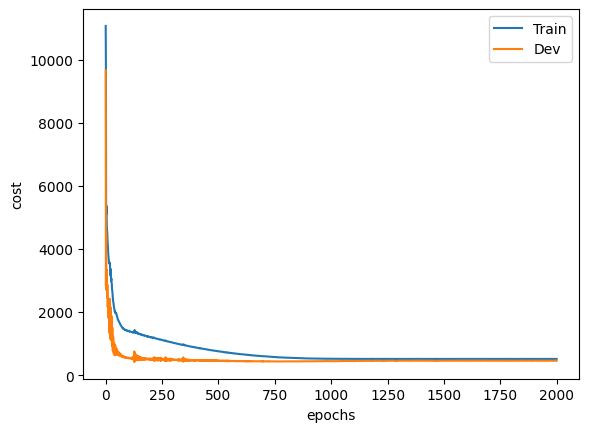

In [192]:
# Training model no 2
final_score_predictor = Neural_network(layer_sizes=[4,5,6,5,4,1], layer_activations=['relu','relu','relu','relu','linear'], 
                                      learning_rate = 0.3, epochs = 2000, dropout = 0.8)

final_score_predictor.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor.test(X_test, Y_test)